## Predict how much energy will a building consume with Fedot.Industrial

Dataset published on Kaggle, aims to assess the value of energy efficiency improvements. For that purpose, four types of sources are identified: electricity, chilled water, steam and hot
water. The goal is to estimate the **energy consumption in kWh**. Dimensions correspond to the air temperature, dew temperature, wind direction and wind speed. These values were taken hourly during a week, and the output is the meter reading of the four aforementioned sources. In this way, was created four datasets:  **ChilledWaterPredictor**, **ElectricityPredictor**, **HotwaterPredictor**, and **SteamPredictor**.
Link to the dataset - https://www.kaggle.com/code/fatmanuranl/ashrae-energy-prediction2

In [1]:
import pandas as pd
from fedot_ind.tools.loader import DataLoader
from examples.example_utils import init_input_data

The list of basic fedot industrial models for experiment are shown below. We using simple linear machine learning pipelines with 3 different feature generators: Statistical, Reccurence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [2]:
from cases.utils import ts_regression_setup
dataset_name = 'ElectricityPredictor'
OperationTypesRepository, tuning_params, data_path, experiment_setup, model_dict = ts_regression_setup()
experiment_setup['output_folder'] = f'./{dataset_name}/results_of_experiment'


Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [4]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2024-01-12 15:40:20,156 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/ElectricityPredictor


In [5]:
input_data = init_input_data(train_data[0], train_data[1], task=tuning_params['task'])
val_data = init_input_data(test_data[0], test_data[1], task=tuning_params['task'])

Lets check our data.

In [6]:
input_data.features.shape

(567, 4, 168)

Lets visualise our predictors.

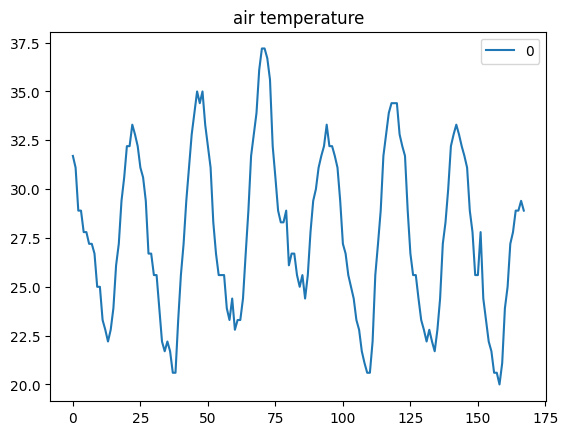

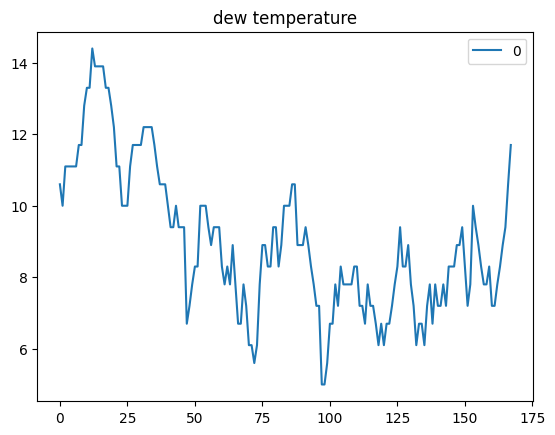

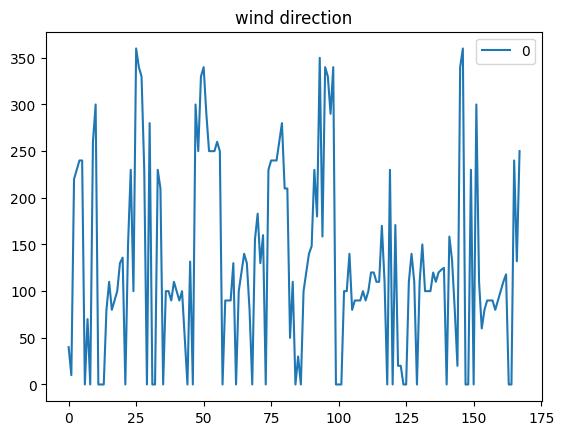

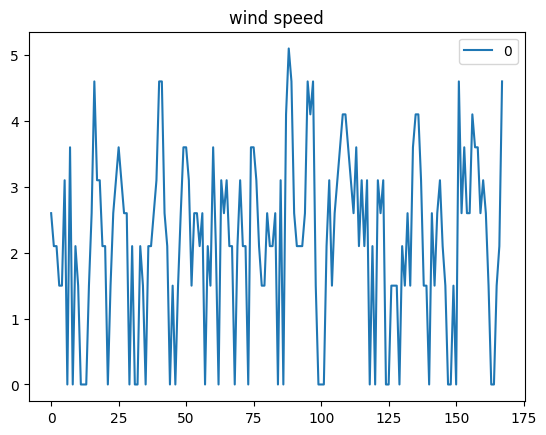

In [7]:
from matplotlib import pyplot as plt
pd.DataFrame(input_data.features[1, 0, :]).plot(title='air temperature')
pd.DataFrame(input_data.features[1, 1, :]).plot(title='dew temperature')
pd.DataFrame(input_data.features[1, 2, :]).plot(title='wind direction')
pd.DataFrame(input_data.features[1, 3, :]).plot(title='wind speed')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [8]:
from cases.utils import evaluate_industrial_model
metric_dict = evaluate_industrial_model(train_data,test_data)

Current_model - regression_with_statistical_features


100%|██████████| 243/243 [00:01<00:00, 165.81it/s]


At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [9]:
df_baseline = pd.concat([x for x in metric_dict.values()],axis=1)
df_baseline.columns = list(metric_dict.keys())
df_baseline = df_baseline.T
df_baseline.sort_values(by='root_mean_squared_error:')
best_baseline = df_baseline.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score
regression_with_statistical_features,0.251014,197808.184612,444.75632,257.159778,135.067006,0.253476,1900.097811,-0.333187


## Could it be done better? Tuning approach

In [12]:
from cases.utils import finetune
finetune(tuning_params, model_dict, train_data, test_data, val_data, input_data)

Current_model - regression_with_statistical_features
2024-01-12 14:32:54,347 - DataSourceSplitter - Stratificated splitting of data is disabled.
2024-01-12 14:32:54,348 - DataSourceSplitter - Hold out validation is applied.
2024-01-12 14:32:54,351 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph


100%|██████████| 114/114 [00:00<00:00, 204.59it/s]


2024-01-12 14:32:58,267 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [ridge, quantile_extractor]}
ridge - {}
quantile_extractor - {'window_size': 0} 
Initial metric: [457.639]
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]2024-01-12 14:32:58,273 - build_posterior_wrapper took 0.001994 seconds
2024-01-12 14:32:58,273 - TPE using 0 trials


  0%|          | 0/453 [00:00<?, ?it/s]

  8%|7         | 36/453 [00:00<00:01, 216.78it/s]

 19%|#8        | 84/453 [00:00<00:01, 197.53it/s]

 24%|##3       | 108/453 [00:00<00:01, 182.40it/s]

 29%|##9       | 132/453 [00:00<00:01, 173.71it/s]

 34%|###4      | 156/453 [00:00<00:01, 165.07it/s]

 40%|###9      | 180/453 [00:01<00:01, 162.61it/s]

 45%|####5     | 204/453 [00:01<00:01, 159.00it/s]

 50%|#####     | 228/453 [00:01<00:01, 156.73it/s]

 56%|#####5    | 252/453 [00:01<00:01, 155.12it/s]

 61%|######    | 276/453 [00:01<00:01, 154.48it/s]

 66%|######6   | 300/453 [00:01<00:00, 153.12it/s]

 72%|#######1  | 324/453 [00:02<00:00, 143.44it/s]

 77%|#######6  | 348/453 [00:02<00:00, 145.53it/s]

 82%|########2 | 372/453 [00:02<00:00, 139.57it/s]

 87%|########7 | 396/453 [00:02<00:00, 133.84it/s]

 93%|#########2| 420/453 [00:02<00:00, 132.47it/s]

 98%|#########8| 444/453 [00:02<00:00, 133.64it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

 32%|###1      | 36/114 [00:00<00:00

 33%|███▎      | 1/3 [00:04<00:08,  4.06s/trial, best loss: 457.63899702121245]2024-01-12 14:33:02,332 - build_posterior_wrapper took 0.000997 seconds
2024-01-12 14:33:02,333 - TPE using 1/1 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  8%|7         | 36/453 [00:00<00:01, 232.83it/s]

 19%|#8        | 84/453 [00:00<00:01, 218.07it/s]

 24%|##3       | 108/453 [00:00<00:01, 193.15it/s]

 29%|##9       | 132/453 [00:00<00:01, 180.70it/s]

 34%|###4      | 156/453 [00:00<00:01, 173.14it/s]

 40%|###9      | 180/453 [00:01<00:01, 162.39it/s]

 45%|####5     | 204/453 [00:01<00:01, 160.63it/s]

 50%|#####     | 228/453 [00:01<00:01, 159.59it/s]

 56%|#####5    | 252/453 [00:01<00:01, 159.02it/s]

 61%|######    | 276/453 [00:01<00:01, 158.49it/s]

 66%|######6   | 300/453 [00:01<00:00, 158.71it/s]

 72%|#######1  | 324/453 [00:01<00:00, 157.66it/s]

 77%|#######6  | 348/453 [00:02<00:00, 156.92it/s]

 82%|########2 | 372/453 [00:02<00:00, 157.51it/s]

 87%|########7 | 396/453 [00:02<00:00, 158.30it/s]

 93%|#########2| 420/453 [00:02<00:00, 158.00it/s]

 98%|#########8| 444/453 [00:02<00:00, 158.57it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

 32%|###1      | 36/114 [00:00<00:00

 67%|██████▋   | 2/3 [00:07<00:03,  3.89s/trial, best loss: 457.63899702121245]2024-01-12 14:33:06,097 - build_posterior_wrapper took 0.000996 seconds
2024-01-12 14:33:06,098 - TPE using 2/2 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  8%|7         | 36/453 [00:00<00:01, 232.92it/s]

 19%|#8        | 84/453 [00:00<00:01, 215.23it/s]

 24%|##3       | 108/453 [00:00<00:01, 192.93it/s]

 29%|##9       | 132/453 [00:00<00:01, 181.42it/s]

 34%|###4      | 156/453 [00:00<00:01, 173.98it/s]

 40%|###9      | 180/453 [00:00<00:01, 168.50it/s]

 45%|####5     | 204/453 [00:01<00:01, 164.23it/s]

 50%|#####     | 228/453 [00:01<00:01, 163.40it/s]

 56%|#####5    | 252/453 [00:01<00:01, 160.13it/s]

 61%|######    | 276/453 [00:01<00:01, 159.74it/s]

 66%|######6   | 300/453 [00:01<00:00, 156.81it/s]

 72%|#######1  | 324/453 [00:01<00:00, 155.95it/s]

 77%|#######6  | 348/453 [00:02<00:00, 155.74it/s]

 82%|########2 | 372/453 [00:02<00:00, 156.67it/s]

 87%|########7 | 396/453 [00:02<00:00, 156.53it/s]

 93%|#########2| 420/453 [00:02<00:00, 156.41it/s]

 98%|#########8| 444/453 [00:02<00:00, 155.59it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

 32%|###1      | 36/114 [00:00<00:00

 10%|█         | 3/30 [00:00<?, ?trial/s, best loss=?]2024-01-12 14:33:09,881 - build_posterior_wrapper took 0.000997 seconds
2024-01-12 14:33:09,882 - TPE using 3/3 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:03, 116.80it/s]

  8%|7         | 36/453 [00:00<00:04, 88.27it/s] 

 11%|#         | 48/453 [00:00<00:05, 77.16it/s]

 13%|#3        | 60/453 [00:00<00:05, 70.91it/s]

 16%|#5        | 72/453 [00:00<00:05, 66.94it/s]

 19%|#8        | 84/453 [00:01<00:05, 64.80it/s]

 21%|##1       | 96/453 [00:01<00:05, 63.54it/s]

 24%|##3       | 108/453 [00:01<00:05, 63.18it/s]

 26%|##6       | 120/453 [00:01<00:05, 62.74it/s]

 29%|##9       | 132/453 [00:01<00:05, 62.84it/s]

 32%|###1      | 144/453 [00:02<00:04, 62.43it/s]

 34%|###4      | 156/453 [00:02<00:04, 61.17it/s]

 37%|###7      | 168/453 [00:02<00:04, 59.15it/s]

 40%|###9      | 180/453 [00:02<00:04, 59.51it/s]

 42%|####2     | 192/453 [00:02<00:04, 60.27it/s]

 45%|####5     | 204/453 [00:03<00:04, 59.84it/s]

 48%|####7     | 216/453 [00:03<00:03, 60.22it/s]

 50%|#####     | 228/453 [00:03<00:03, 60.33it/s]

 53%|#####2    | 240/453 [00:03<00:03, 60.89it

 13%|█▎        | 4/30 [00:09<04:13,  9.74s/trial, best loss: 457.63899702121245]2024-01-12 14:33:19,627 - build_posterior_wrapper took 0.000998 seconds
2024-01-12 14:33:19,628 - TPE using 4/4 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:03, 116.82it/s]

  5%|5         | 24/453 [00:00<00:03, 116.16it/s]

  8%|7         | 36/453 [00:00<00:05, 79.66it/s] 

 11%|#         | 48/453 [00:00<00:05, 69.58it/s]

 13%|#3        | 60/453 [00:00<00:06, 64.23it/s]

 16%|#5        | 72/453 [00:01<00:06, 61.74it/s]

 19%|#8        | 84/453 [00:01<00:06, 60.65it/s]

 21%|##1       | 96/453 [00:01<00:05, 59.68it/s]

 24%|##3       | 108/453 [00:01<00:05, 59.11it/s]

 26%|##6       | 120/453 [00:01<00:05, 59.06it/s]

 29%|##9       | 132/453 [00:02<00:05, 58.73it/s]

 32%|###1      | 144/453 [00:02<00:05, 58.20it/s]

 34%|###4      | 156/453 [00:02<00:05, 57.66it/s]

 37%|###7      | 168/453 [00:02<00:04, 57.52it/s]

 40%|###9      | 180/453 [00:02<00:04, 57.60it/s]

 42%|####2     | 192/453 [00:03<00:04, 57.58it/s]

 45%|####5     | 204/453 [00:03<00:04, 57.75it/s]

 48%|####7     | 216/453 [00:03<00:04, 57.28it/s]

 50%|#####     | 228/453 [00:03<00:03, 57.10it

 17%|█▋        | 5/30 [00:20<04:12, 10.09s/trial, best loss: 457.63899702121245]2024-01-12 14:33:29,960 - build_posterior_wrapper took 0.000976 seconds
2024-01-12 14:33:29,961 - TPE using 5/5 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:03, 117.46it/s]

  5%|5         | 24/453 [00:00<00:03, 117.08it/s]

  8%|7         | 36/453 [00:00<00:05, 82.53it/s] 

 11%|#         | 48/453 [00:00<00:05, 70.20it/s]

 13%|#3        | 60/453 [00:00<00:05, 66.24it/s]

 16%|#5        | 72/453 [00:01<00:05, 64.74it/s]

 19%|#8        | 84/453 [00:01<00:05, 62.48it/s]

 21%|##1       | 96/453 [00:01<00:05, 62.02it/s]

 24%|##3       | 108/453 [00:01<00:05, 57.73it/s]

 26%|##6       | 120/453 [00:01<00:05, 57.36it/s]

 29%|##9       | 132/453 [00:02<00:05, 58.10it/s]

 32%|###1      | 144/453 [00:02<00:05, 56.05it/s]

 34%|###4      | 156/453 [00:02<00:05, 56.83it/s]

 37%|###7      | 168/453 [00:02<00:04, 57.62it/s]

 40%|###9      | 180/453 [00:02<00:04, 59.11it/s]

 42%|####2     | 192/453 [00:03<00:04, 59.91it/s]

 45%|####5     | 204/453 [00:03<00:04, 59.52it/s]

 48%|####7     | 216/453 [00:03<00:03, 60.12it/s]

 50%|#####     | 228/453 [00:03<00:03, 60.45it

 20%|██        | 6/30 [00:30<04:02, 10.12s/trial, best loss: 457.63899702121245]2024-01-12 14:33:40,114 - build_posterior_wrapper took 0.000996 seconds
2024-01-12 14:33:40,115 - TPE using 6/6 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:05, 81.29it/s]

  5%|5         | 24/453 [00:00<00:05, 82.11it/s]

  8%|7         | 36/453 [00:00<00:07, 57.26it/s]

 11%|#         | 48/453 [00:00<00:08, 50.38it/s]

 13%|#3        | 60/453 [00:01<00:08, 46.40it/s]

 16%|#5        | 72/453 [00:01<00:08, 44.43it/s]

 19%|#8        | 84/453 [00:01<00:08, 43.33it/s]

 21%|##1       | 96/453 [00:02<00:08, 42.70it/s]

 24%|##3       | 108/453 [00:02<00:08, 42.47it/s]

 26%|##6       | 120/453 [00:02<00:07, 42.11it/s]

 29%|##9       | 132/453 [00:02<00:07, 41.98it/s]

 32%|###1      | 144/453 [00:03<00:07, 41.98it/s]

 34%|###4      | 156/453 [00:03<00:07, 42.04it/s]

 37%|###7      | 168/453 [00:03<00:06, 40.86it/s]

 40%|###9      | 180/453 [00:04<00:06, 41.15it/s]

 42%|####2     | 192/453 [00:04<00:06, 41.59it/s]

 45%|####5     | 204/453 [00:04<00:05, 41.73it/s]

 48%|####7     | 216/453 [00:04<00:05, 41.94it/s]

 50%|#####     | 228/453 [00:05<00:05, 41.85it/s]

 23%|██▎       | 7/30 [00:44<04:29, 11.71s/trial, best loss: 457.63899702121245]2024-01-12 14:33:54,274 - build_posterior_wrapper took 0.001952 seconds
2024-01-12 14:33:54,275 - TPE using 7/7 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:03, 110.91it/s]

  5%|5         | 24/453 [00:00<00:03, 110.30it/s]

  8%|7         | 36/453 [00:00<00:05, 73.60it/s] 

 11%|#         | 48/453 [00:00<00:06, 64.83it/s]

 13%|#3        | 60/453 [00:00<00:06, 59.97it/s]

 16%|#5        | 72/453 [00:01<00:06, 57.90it/s]

 19%|#8        | 84/453 [00:01<00:06, 56.16it/s]

 21%|##1       | 96/453 [00:01<00:06, 55.44it/s]

 24%|##3       | 108/453 [00:01<00:06, 55.41it/s]

 26%|##6       | 120/453 [00:01<00:06, 55.07it/s]

 29%|##9       | 132/453 [00:02<00:05, 54.91it/s]

 32%|###1      | 144/453 [00:02<00:05, 54.43it/s]

 34%|###4      | 156/453 [00:02<00:05, 54.47it/s]

 37%|###7      | 168/453 [00:02<00:05, 54.36it/s]

 40%|###9      | 180/453 [00:03<00:05, 54.24it/s]

 42%|####2     | 192/453 [00:03<00:04, 54.07it/s]

 45%|####5     | 204/453 [00:03<00:04, 53.78it/s]

 48%|####7     | 216/453 [00:03<00:04, 54.30it/s]

 50%|#####     | 228/453 [00:03<00:04, 53.97it

 27%|██▋       | 8/30 [00:55<04:11, 11.42s/trial, best loss: 457.63899702121245]2024-01-12 14:34:05,178 - build_posterior_wrapper took 0.000998 seconds
2024-01-12 14:34:05,178 - TPE using 8/8 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:05, 84.09it/s]

  5%|5         | 24/453 [00:00<00:05, 85.03it/s]

  8%|7         | 36/453 [00:00<00:07, 58.42it/s]

 11%|#         | 48/453 [00:00<00:07, 50.87it/s]

 13%|#3        | 60/453 [00:01<00:08, 47.47it/s]

 16%|#5        | 72/453 [00:01<00:08, 46.08it/s]

 19%|#8        | 84/453 [00:01<00:08, 44.96it/s]

 21%|##1       | 96/453 [00:01<00:08, 44.62it/s]

 24%|##3       | 108/453 [00:02<00:07, 44.15it/s]

 26%|##6       | 120/453 [00:02<00:07, 44.14it/s]

 29%|##9       | 132/453 [00:02<00:07, 43.88it/s]

 32%|###1      | 144/453 [00:03<00:07, 43.72it/s]

 34%|###4      | 156/453 [00:03<00:07, 42.34it/s]

 37%|###7      | 168/453 [00:03<00:06, 42.56it/s]

 40%|###9      | 180/453 [00:03<00:06, 42.77it/s]

 42%|####2     | 192/453 [00:04<00:06, 42.24it/s]

 45%|####5     | 204/453 [00:04<00:05, 42.47it/s]

 48%|####7     | 216/453 [00:04<00:05, 42.62it/s]

 50%|#####     | 228/453 [00:05<00:05, 42.80it/s]

 30%|███       | 9/30 [01:08<04:15, 12.17s/trial, best loss: 457.63899702121245]2024-01-12 14:34:18,808 - build_posterior_wrapper took 0.000972 seconds
2024-01-12 14:34:18,809 - TPE using 9/9 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:05, 85.33it/s]

  5%|5         | 24/453 [00:00<00:05, 84.62it/s]

  8%|7         | 36/453 [00:00<00:07, 58.66it/s]

 11%|#         | 48/453 [00:00<00:07, 51.36it/s]

 13%|#3        | 60/453 [00:01<00:08, 48.12it/s]

 16%|#5        | 72/453 [00:01<00:08, 46.23it/s]

 19%|#8        | 84/453 [00:01<00:08, 45.18it/s]

 21%|##1       | 96/453 [00:01<00:07, 44.66it/s]

 24%|##3       | 108/453 [00:02<00:07, 43.87it/s]

 26%|##6       | 120/453 [00:02<00:07, 43.61it/s]

 29%|##9       | 132/453 [00:02<00:07, 43.34it/s]

 32%|###1      | 144/453 [00:03<00:07, 43.36it/s]

 34%|###4      | 156/453 [00:03<00:06, 42.94it/s]

 37%|###7      | 168/453 [00:03<00:06, 42.94it/s]

 40%|###9      | 180/453 [00:03<00:06, 43.10it/s]

 42%|####2     | 192/453 [00:04<00:06, 43.30it/s]

 45%|####5     | 204/453 [00:04<00:05, 43.10it/s]

 48%|####7     | 216/453 [00:04<00:05, 42.75it/s]

 50%|#####     | 228/453 [00:05<00:05, 42.88it/s]

 33%|███▎      | 10/30 [01:22<04:13, 12.69s/trial, best loss: 457.63899702121245]2024-01-12 14:34:32,573 - build_posterior_wrapper took 0.002025 seconds
2024-01-12 14:34:32,574 - TPE using 10/10 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:05, 85.35it/s]

  5%|5         | 24/453 [00:00<00:04, 86.42it/s]

  8%|7         | 36/453 [00:00<00:06, 60.48it/s]

 11%|#         | 48/453 [00:00<00:07, 52.06it/s]

 13%|#3        | 60/453 [00:01<00:08, 48.94it/s]

 16%|#5        | 72/453 [00:01<00:07, 47.68it/s]

 19%|#8        | 84/453 [00:01<00:07, 46.43it/s]

 21%|##1       | 96/453 [00:01<00:07, 45.98it/s]

 24%|##3       | 108/453 [00:02<00:07, 45.10it/s]

 26%|##6       | 120/453 [00:02<00:07, 44.68it/s]

 29%|##9       | 132/453 [00:02<00:07, 44.49it/s]

 32%|###1      | 144/453 [00:02<00:06, 44.42it/s]

 34%|###4      | 156/453 [00:03<00:06, 43.97it/s]

 37%|###7      | 168/453 [00:03<00:06, 43.48it/s]

 40%|###9      | 180/453 [00:03<00:06, 43.82it/s]

 42%|####2     | 192/453 [00:04<00:05, 43.91it/s]

 45%|####5     | 204/453 [00:04<00:05, 43.39it/s]

 48%|####7     | 216/453 [00:04<00:05, 43.53it/s]

 50%|#####     | 228/453 [00:04<00:05, 43.76it/s]

 37%|███▋      | 11/30 [01:36<04:05, 12.93s/trial, best loss: 457.63899702121245]2024-01-12 14:34:46,015 - build_posterior_wrapper took 0.000994 seconds
2024-01-12 14:34:46,016 - TPE using 11/11 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:06, 72.05it/s]

  5%|5         | 24/453 [00:00<00:05, 76.07it/s]

  8%|7         | 36/453 [00:00<00:07, 53.97it/s]

 11%|#         | 48/453 [00:00<00:08, 48.05it/s]

 13%|#3        | 60/453 [00:01<00:08, 45.01it/s]

 16%|#5        | 72/453 [00:01<00:08, 43.45it/s]

 19%|#8        | 84/453 [00:01<00:08, 41.91it/s]

 21%|##1       | 96/453 [00:02<00:08, 41.41it/s]

 24%|##3       | 108/453 [00:02<00:08, 40.97it/s]

 26%|##6       | 120/453 [00:02<00:08, 40.29it/s]

 29%|##9       | 132/453 [00:03<00:07, 40.25it/s]

 32%|###1      | 144/453 [00:03<00:07, 39.97it/s]

 34%|###4      | 156/453 [00:03<00:07, 39.88it/s]

 37%|###7      | 168/453 [00:03<00:07, 39.69it/s]

 40%|###9      | 180/453 [00:04<00:06, 39.91it/s]

 42%|####2     | 192/453 [00:04<00:06, 39.96it/s]

 45%|####5     | 204/453 [00:04<00:06, 40.06it/s]

 48%|####7     | 216/453 [00:05<00:05, 40.01it/s]

 50%|#####     | 228/453 [00:05<00:05, 40.19it/s]

 40%|████      | 12/30 [01:50<04:02, 13.49s/trial, best loss: 457.63899702121245]2024-01-12 14:35:00,716 - build_posterior_wrapper took 0.000999 seconds
2024-01-12 14:35:00,717 - TPE using 12/12 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:05, 83.56it/s]

  5%|5         | 24/453 [00:00<00:05, 83.56it/s]

  8%|7         | 36/453 [00:00<00:07, 57.17it/s]

 11%|#         | 48/453 [00:00<00:08, 50.49it/s]

 13%|#3        | 60/453 [00:01<00:08, 47.18it/s]

 16%|#5        | 72/453 [00:01<00:08, 45.21it/s]

 19%|#8        | 84/453 [00:01<00:08, 43.90it/s]

 21%|##1       | 96/453 [00:02<00:08, 43.26it/s]

 24%|##3       | 108/453 [00:02<00:07, 43.17it/s]

 26%|##6       | 120/453 [00:02<00:07, 42.62it/s]

 29%|##9       | 132/453 [00:02<00:07, 42.38it/s]

 32%|###1      | 144/453 [00:03<00:07, 42.27it/s]

 34%|###4      | 156/453 [00:03<00:07, 42.21it/s]

 37%|###7      | 168/453 [00:03<00:06, 42.19it/s]

 40%|###9      | 180/453 [00:03<00:06, 42.24it/s]

 42%|####2     | 192/453 [00:04<00:06, 42.08it/s]

 45%|####5     | 204/453 [00:04<00:05, 41.91it/s]

 48%|####7     | 216/453 [00:04<00:05, 41.83it/s]

 50%|#####     | 228/453 [00:05<00:05, 41.42it/s]

 43%|████▎     | 13/30 [02:05<03:53, 13.72s/trial, best loss: 457.63899702121245]2024-01-12 14:35:14,962 - build_posterior_wrapper took 0.001006 seconds
2024-01-12 14:35:14,963 - TPE using 13/13 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:05, 77.63it/s]

  5%|5         | 24/453 [00:00<00:05, 77.82it/s]

  8%|7         | 36/453 [00:00<00:07, 54.11it/s]

 11%|#         | 48/453 [00:00<00:08, 47.79it/s]

 13%|#3        | 60/453 [00:01<00:08, 44.15it/s]

 16%|#5        | 72/453 [00:01<00:08, 42.48it/s]

 19%|#8        | 84/453 [00:01<00:08, 41.96it/s]

 21%|##1       | 96/453 [00:02<00:08, 41.37it/s]

 24%|##3       | 108/453 [00:02<00:08, 40.95it/s]

 26%|##6       | 120/453 [00:02<00:08, 40.50it/s]

 29%|##9       | 132/453 [00:03<00:07, 40.36it/s]

 32%|###1      | 144/453 [00:03<00:07, 40.44it/s]

 34%|###4      | 156/453 [00:03<00:07, 40.41it/s]

 37%|###7      | 168/453 [00:03<00:07, 40.37it/s]

 40%|###9      | 180/453 [00:04<00:06, 40.43it/s]

 42%|####2     | 192/453 [00:04<00:06, 40.11it/s]

 45%|####5     | 204/453 [00:04<00:06, 40.34it/s]

 48%|####7     | 216/453 [00:05<00:05, 40.25it/s]

 50%|#####     | 228/453 [00:05<00:05, 40.12it/s]

 47%|████▋     | 14/30 [02:20<03:46, 14.13s/trial, best loss: 457.63899702121245]2024-01-12 14:35:30,014 - build_posterior_wrapper took 0.002013 seconds
2024-01-12 14:35:30,015 - TPE using 14/14 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:05, 85.35it/s]

  5%|5         | 24/453 [00:00<00:04, 86.79it/s]

  8%|7         | 36/453 [00:00<00:06, 60.30it/s]

 11%|#         | 48/453 [00:00<00:07, 53.16it/s]

 13%|#3        | 60/453 [00:01<00:07, 49.81it/s]

 16%|#5        | 72/453 [00:01<00:07, 47.64it/s]

 19%|#8        | 84/453 [00:01<00:07, 46.24it/s]

 21%|##1       | 96/453 [00:01<00:07, 45.25it/s]

 24%|##3       | 108/453 [00:02<00:07, 44.72it/s]

 26%|##6       | 120/453 [00:02<00:07, 44.36it/s]

 29%|##9       | 132/453 [00:02<00:07, 44.03it/s]

 32%|###1      | 144/453 [00:03<00:06, 44.39it/s]

 34%|###4      | 156/453 [00:03<00:06, 44.09it/s]

 37%|###7      | 168/453 [00:03<00:06, 44.23it/s]

 40%|###9      | 180/453 [00:03<00:06, 43.98it/s]

 42%|####2     | 192/453 [00:04<00:05, 44.14it/s]

 45%|####5     | 204/453 [00:04<00:05, 43.95it/s]

 48%|####7     | 216/453 [00:04<00:05, 43.12it/s]

 50%|#####     | 228/453 [00:04<00:05, 43.28it/s]

 50%|█████     | 15/30 [02:33<03:28, 13.92s/trial, best loss: 457.63899702121245]2024-01-12 14:35:43,460 - build_posterior_wrapper took 0.000998 seconds
2024-01-12 14:35:43,461 - TPE using 15/15 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:04, 109.49it/s]

  5%|5         | 24/453 [00:00<00:03, 113.36it/s]

  8%|7         | 36/453 [00:00<00:05, 78.82it/s] 

 11%|#         | 48/453 [00:00<00:05, 69.58it/s]

 13%|#3        | 60/453 [00:00<00:06, 64.34it/s]

 16%|#5        | 72/453 [00:01<00:06, 61.38it/s]

 19%|#8        | 84/453 [00:01<00:06, 59.50it/s]

 21%|##1       | 96/453 [00:01<00:06, 58.85it/s]

 24%|##3       | 108/453 [00:01<00:05, 58.46it/s]

 26%|##6       | 120/453 [00:01<00:05, 57.42it/s]

 29%|##9       | 132/453 [00:02<00:05, 57.21it/s]

 32%|###1      | 144/453 [00:02<00:05, 56.87it/s]

 34%|###4      | 156/453 [00:02<00:05, 57.04it/s]

 37%|###7      | 168/453 [00:02<00:05, 56.91it/s]

 40%|###9      | 180/453 [00:02<00:04, 56.30it/s]

 42%|####2     | 192/453 [00:03<00:04, 56.63it/s]

 45%|####5     | 204/453 [00:03<00:04, 56.24it/s]

 48%|####7     | 216/453 [00:03<00:04, 56.72it/s]

 50%|#####     | 228/453 [00:03<00:03, 56.81it

 53%|█████▎    | 16/30 [02:44<03:00, 12.92s/trial, best loss: 457.63899702121245]2024-01-12 14:35:54,085 - build_posterior_wrapper took 0.000997 seconds
2024-01-12 14:35:54,086 - TPE using 16/16 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:03, 115.69it/s]

  5%|5         | 24/453 [00:00<00:03, 115.71it/s]

  8%|7         | 36/453 [00:00<00:05, 81.14it/s] 

 11%|#         | 48/453 [00:00<00:05, 70.49it/s]

 13%|#3        | 60/453 [00:00<00:05, 65.86it/s]

 16%|#5        | 72/453 [00:01<00:06, 63.11it/s]

 19%|#8        | 84/453 [00:01<00:06, 61.45it/s]

 21%|##1       | 96/453 [00:01<00:05, 60.89it/s]

 24%|##3       | 108/453 [00:01<00:05, 60.28it/s]

 26%|##6       | 120/453 [00:01<00:05, 60.15it/s]

 29%|##9       | 132/453 [00:02<00:05, 59.65it/s]

 32%|###1      | 144/453 [00:02<00:05, 59.31it/s]

 34%|###4      | 156/453 [00:02<00:04, 59.70it/s]

 37%|###7      | 168/453 [00:02<00:04, 59.57it/s]

 40%|###9      | 180/453 [00:02<00:04, 59.46it/s]

 42%|####2     | 192/453 [00:03<00:04, 59.48it/s]

 45%|####5     | 204/453 [00:03<00:04, 59.24it/s]

 48%|####7     | 216/453 [00:03<00:03, 59.39it/s]

 50%|#####     | 228/453 [00:03<00:03, 59.41it

 57%|█████▋    | 17/30 [02:54<02:36, 12.04s/trial, best loss: 457.63899702121245]2024-01-12 14:36:04,097 - build_posterior_wrapper took 0.001005 seconds
2024-01-12 14:36:04,098 - TPE using 17/17 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:04, 95.87it/s]

  5%|5         | 24/453 [00:00<00:04, 96.55it/s]

  8%|7         | 36/453 [00:00<00:06, 68.57it/s]

 11%|#         | 48/453 [00:00<00:06, 59.67it/s]

 13%|#3        | 60/453 [00:00<00:07, 54.92it/s]

 16%|#5        | 72/453 [00:01<00:07, 52.88it/s]

 19%|#8        | 84/453 [00:01<00:07, 51.98it/s]

 21%|##1       | 96/453 [00:01<00:07, 50.87it/s]

 24%|##3       | 108/453 [00:01<00:06, 50.82it/s]

 26%|##6       | 120/453 [00:02<00:06, 50.67it/s]

 29%|##9       | 132/453 [00:02<00:06, 50.70it/s]

 32%|###1      | 144/453 [00:02<00:06, 50.59it/s]

 34%|###4      | 156/453 [00:02<00:05, 50.36it/s]

 37%|###7      | 168/453 [00:03<00:05, 50.32it/s]

 40%|###9      | 180/453 [00:03<00:05, 50.22it/s]

 42%|####2     | 192/453 [00:03<00:05, 50.08it/s]

 45%|####5     | 204/453 [00:03<00:04, 50.03it/s]

 48%|####7     | 216/453 [00:04<00:04, 49.46it/s]

 50%|#####     | 228/453 [00:04<00:04, 49.09it/s]

 60%|██████    | 18/30 [03:06<02:23, 11.99s/trial, best loss: 457.63899702121245]2024-01-12 14:36:15,948 - build_posterior_wrapper took 0.001994 seconds
2024-01-12 14:36:15,948 - TPE using 18/18 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:03, 110.38it/s]

  5%|5         | 24/453 [00:00<00:03, 112.82it/s]

  8%|7         | 36/453 [00:00<00:05, 79.02it/s] 

 11%|#         | 48/453 [00:00<00:05, 69.69it/s]

 13%|#3        | 60/453 [00:00<00:06, 65.27it/s]

 16%|#5        | 72/453 [00:01<00:05, 63.63it/s]

 19%|#8        | 84/453 [00:01<00:05, 61.82it/s]

 21%|##1       | 96/453 [00:01<00:05, 61.09it/s]

 24%|##3       | 108/453 [00:01<00:05, 60.60it/s]

 26%|##6       | 120/453 [00:01<00:05, 59.60it/s]

 29%|##9       | 132/453 [00:02<00:05, 59.86it/s]

 32%|###1      | 144/453 [00:02<00:05, 59.62it/s]

 34%|###4      | 156/453 [00:02<00:04, 59.60it/s]

 37%|###7      | 168/453 [00:02<00:04, 60.03it/s]

 40%|###9      | 180/453 [00:02<00:04, 59.86it/s]

 42%|####2     | 192/453 [00:03<00:04, 59.89it/s]

 45%|####5     | 204/453 [00:03<00:04, 59.59it/s]

 48%|####7     | 216/453 [00:03<00:03, 59.26it/s]

 50%|#####     | 228/453 [00:03<00:03, 58.73it

 63%|██████▎   | 19/30 [03:16<02:05, 11.44s/trial, best loss: 457.63899702121245]2024-01-12 14:36:26,121 - build_posterior_wrapper took 0.000996 seconds
2024-01-12 14:36:26,122 - TPE using 19/19 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:04, 89.79it/s]

  5%|5         | 24/453 [00:00<00:04, 94.78it/s]

  8%|7         | 36/453 [00:00<00:06, 66.70it/s]

 11%|#         | 48/453 [00:00<00:06, 58.77it/s]

 13%|#3        | 60/453 [00:00<00:07, 55.70it/s]

 16%|#5        | 72/453 [00:01<00:07, 53.92it/s]

 19%|#8        | 84/453 [00:01<00:07, 52.25it/s]

 21%|##1       | 96/453 [00:01<00:06, 51.63it/s]

 24%|##3       | 108/453 [00:01<00:06, 51.49it/s]

 26%|##6       | 120/453 [00:02<00:06, 50.53it/s]

 29%|##9       | 132/453 [00:02<00:06, 50.20it/s]

 32%|###1      | 144/453 [00:02<00:06, 50.48it/s]

 34%|###4      | 156/453 [00:02<00:05, 50.79it/s]

 37%|###7      | 168/453 [00:03<00:05, 50.99it/s]

 40%|###9      | 180/453 [00:03<00:05, 51.49it/s]

 42%|####2     | 192/453 [00:03<00:05, 51.65it/s]

 45%|####5     | 204/453 [00:03<00:04, 52.05it/s]

 48%|####7     | 216/453 [00:04<00:04, 51.96it/s]

 50%|#####     | 228/453 [00:04<00:04, 51.74it/s]

 67%|██████▋   | 20/30 [03:27<01:54, 11.48s/trial, best loss: 457.63899702121245]2024-01-12 14:36:37,680 - build_posterior_wrapper took 0.001003 seconds
2024-01-12 14:36:37,680 - TPE using 20/20 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:05, 74.73it/s]

  5%|5         | 24/453 [00:00<00:05, 75.42it/s]

  8%|7         | 36/453 [00:00<00:07, 52.40it/s]

 11%|#         | 48/453 [00:00<00:08, 45.97it/s]

 13%|#3        | 60/453 [00:01<00:09, 41.76it/s]

 16%|#5        | 72/453 [00:01<00:09, 39.56it/s]

 19%|#8        | 84/453 [00:01<00:09, 38.98it/s]

 21%|##1       | 96/453 [00:02<00:09, 38.72it/s]

 24%|##3       | 108/453 [00:02<00:08, 38.89it/s]

 26%|##6       | 120/453 [00:02<00:08, 39.15it/s]

 29%|##9       | 132/453 [00:03<00:08, 39.18it/s]

 32%|###1      | 144/453 [00:03<00:07, 39.26it/s]

 34%|###4      | 156/453 [00:03<00:07, 39.30it/s]

 37%|###7      | 168/453 [00:04<00:07, 39.26it/s]

 40%|###9      | 180/453 [00:04<00:06, 39.30it/s]

 42%|####2     | 192/453 [00:04<00:06, 38.67it/s]

 45%|####5     | 204/453 [00:05<00:06, 38.86it/s]

 48%|####7     | 216/453 [00:05<00:06, 38.94it/s]

 50%|#####     | 228/453 [00:05<00:06, 36.69it/s]

 70%|███████   | 21/30 [03:42<01:52, 12.53s/trial, best loss: 457.63899702121245]2024-01-12 14:36:52,664 - build_posterior_wrapper took 0.000997 seconds
2024-01-12 14:36:52,665 - TPE using 21/21 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:04, 99.44it/s]

  5%|5         | 24/453 [00:00<00:04, 101.83it/s]

  8%|7         | 36/453 [00:00<00:05, 71.11it/s] 

 11%|#         | 48/453 [00:00<00:06, 62.35it/s]

 13%|#3        | 60/453 [00:00<00:06, 58.26it/s]

 16%|#5        | 72/453 [00:01<00:06, 55.61it/s]

 19%|#8        | 84/453 [00:01<00:06, 54.41it/s]

 21%|##1       | 96/453 [00:01<00:06, 53.85it/s]

 24%|##3       | 108/453 [00:01<00:06, 53.06it/s]

 26%|##6       | 120/453 [00:02<00:06, 52.67it/s]

 29%|##9       | 132/453 [00:02<00:06, 51.59it/s]

 32%|###1      | 144/453 [00:02<00:05, 51.74it/s]

 34%|###4      | 156/453 [00:02<00:05, 51.54it/s]

 37%|###7      | 168/453 [00:03<00:05, 51.91it/s]

 40%|###9      | 180/453 [00:03<00:05, 51.41it/s]

 42%|####2     | 192/453 [00:03<00:05, 51.38it/s]

 45%|####5     | 204/453 [00:03<00:04, 50.96it/s]

 48%|####7     | 216/453 [00:03<00:04, 51.29it/s]

 50%|#####     | 228/453 [00:04<00:04, 51.68it/

 73%|███████▎  | 22/30 [03:54<01:37, 12.24s/trial, best loss: 457.63899702121245]2024-01-12 14:37:04,229 - build_posterior_wrapper took 0.001027 seconds
2024-01-12 14:37:04,231 - TPE using 22/22 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:04, 90.47it/s]

  5%|5         | 24/453 [00:00<00:04, 89.46it/s]

  8%|7         | 36/453 [00:00<00:06, 63.69it/s]

 11%|#         | 48/453 [00:00<00:07, 55.56it/s]

 13%|#3        | 60/453 [00:01<00:07, 51.89it/s]

 16%|#5        | 72/453 [00:01<00:07, 49.66it/s]

 19%|#8        | 84/453 [00:01<00:07, 48.86it/s]

 21%|##1       | 96/453 [00:01<00:07, 48.04it/s]

 24%|##3       | 108/453 [00:02<00:07, 47.57it/s]

 26%|##6       | 120/453 [00:02<00:07, 46.73it/s]

 29%|##9       | 132/453 [00:02<00:07, 45.29it/s]

 32%|###1      | 144/453 [00:02<00:06, 45.71it/s]

 34%|###4      | 156/453 [00:03<00:06, 45.59it/s]

 37%|###7      | 168/453 [00:03<00:06, 45.29it/s]

 40%|###9      | 180/453 [00:03<00:05, 45.66it/s]

 42%|####2     | 192/453 [00:03<00:05, 45.75it/s]

 45%|####5     | 204/453 [00:04<00:05, 45.93it/s]

 48%|####7     | 216/453 [00:04<00:05, 46.05it/s]

 50%|#####     | 228/453 [00:04<00:04, 46.51it/s]

 77%|███████▋  | 23/30 [04:07<01:26, 12.40s/trial, best loss: 457.63899702121245]2024-01-12 14:37:17,009 - build_posterior_wrapper took 0.001001 seconds
2024-01-12 14:37:17,010 - TPE using 23/23 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:04, 95.52it/s]

  5%|5         | 24/453 [00:00<00:04, 93.75it/s]

  8%|7         | 36/453 [00:00<00:06, 65.86it/s]

 11%|#         | 48/453 [00:00<00:06, 58.15it/s]

 13%|#3        | 60/453 [00:00<00:07, 53.92it/s]

 16%|#5        | 72/453 [00:01<00:07, 51.93it/s]

 19%|#8        | 84/453 [00:01<00:07, 50.86it/s]

 21%|##1       | 96/453 [00:01<00:07, 49.82it/s]

 24%|##3       | 108/453 [00:01<00:06, 49.71it/s]

 26%|##6       | 120/453 [00:02<00:06, 49.51it/s]

 29%|##9       | 132/453 [00:02<00:06, 49.20it/s]

 32%|###1      | 144/453 [00:02<00:06, 49.33it/s]

 34%|###4      | 156/453 [00:02<00:06, 49.24it/s]

 37%|###7      | 168/453 [00:03<00:05, 49.38it/s]

 40%|###9      | 180/453 [00:03<00:05, 49.54it/s]

 42%|####2     | 192/453 [00:03<00:05, 49.57it/s]

 45%|####5     | 204/453 [00:03<00:05, 47.32it/s]

 48%|####7     | 216/453 [00:04<00:05, 46.97it/s]

 50%|#####     | 228/453 [00:04<00:04, 47.37it/s]

 80%|████████  | 24/30 [04:19<01:13, 12.33s/trial, best loss: 457.63899702121245]2024-01-12 14:37:29,155 - build_posterior_wrapper took 0.000997 seconds
2024-01-12 14:37:29,156 - TPE using 24/24 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  8%|7         | 36/453 [00:00<00:01, 223.52it/s]

 19%|#8        | 84/453 [00:00<00:01, 201.88it/s]

 24%|##3       | 108/453 [00:00<00:01, 183.19it/s]

 29%|##9       | 132/453 [00:00<00:01, 172.33it/s]

 34%|###4      | 156/453 [00:00<00:01, 164.83it/s]

 40%|###9      | 180/453 [00:01<00:01, 159.63it/s]

 45%|####5     | 204/453 [00:01<00:01, 157.23it/s]

 50%|#####     | 228/453 [00:01<00:01, 155.01it/s]

 56%|#####5    | 252/453 [00:01<00:01, 154.69it/s]

 61%|######    | 276/453 [00:01<00:01, 153.88it/s]

 66%|######6   | 300/453 [00:01<00:00, 154.59it/s]

 72%|#######1  | 324/453 [00:01<00:00, 153.89it/s]

 77%|#######6  | 348/453 [00:02<00:00, 152.24it/s]

 82%|########2 | 372/453 [00:02<00:00, 151.40it/s]

 87%|########7 | 396/453 [00:02<00:00, 151.38it/s]

 93%|#########2| 420/453 [00:02<00:00, 151.94it/s]

 98%|#########8| 444/453 [00:02<00:00, 153.06it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

 32%|###1      | 36/114 [00:00<00:00

 83%|████████▎ | 25/30 [04:23<00:48,  9.79s/trial, best loss: 457.63899702121245]2024-01-12 14:37:33,049 - build_posterior_wrapper took 0.000998 seconds
2024-01-12 14:37:33,050 - TPE using 25/25 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:05, 85.33it/s]

  5%|5         | 24/453 [00:00<00:05, 83.59it/s]

  8%|7         | 36/453 [00:00<00:07, 58.13it/s]

 11%|#         | 48/453 [00:00<00:07, 51.04it/s]

 13%|#3        | 60/453 [00:01<00:08, 47.55it/s]

 16%|#5        | 72/453 [00:01<00:08, 45.77it/s]

 19%|#8        | 84/453 [00:01<00:08, 44.76it/s]

 21%|##1       | 96/453 [00:01<00:08, 44.18it/s]

 24%|##3       | 108/453 [00:02<00:07, 43.79it/s]

 26%|##6       | 120/453 [00:02<00:07, 43.16it/s]

 29%|##9       | 132/453 [00:02<00:07, 42.82it/s]

 32%|###1      | 144/453 [00:03<00:07, 42.96it/s]

 34%|###4      | 156/453 [00:03<00:06, 43.15it/s]

 37%|###7      | 168/453 [00:03<00:06, 43.24it/s]

 40%|###9      | 180/453 [00:03<00:06, 43.08it/s]

 42%|####2     | 192/453 [00:04<00:06, 43.06it/s]

 45%|####5     | 204/453 [00:04<00:05, 43.08it/s]

 48%|####7     | 216/453 [00:04<00:05, 43.14it/s]

 50%|#####     | 228/453 [00:05<00:05, 43.35it/s]

 87%|████████▋ | 26/30 [04:36<00:43, 10.94s/trial, best loss: 457.63899702121245]2024-01-12 14:37:46,648 - build_posterior_wrapper took 0.000995 seconds
2024-01-12 14:37:46,649 - TPE using 26/26 trials with best loss 457.638997


  0%|          | 0/453 [00:00<?, ?it/s]

  3%|2         | 12/453 [00:00<00:04, 95.12it/s]

  5%|5         | 24/453 [00:00<00:04, 94.02it/s]

  8%|7         | 36/453 [00:00<00:06, 65.34it/s]

 11%|#         | 48/453 [00:00<00:07, 55.48it/s]

 13%|#3        | 60/453 [00:01<00:07, 52.38it/s]

 16%|#5        | 72/453 [00:01<00:07, 50.85it/s]

 19%|#8        | 84/453 [00:01<00:07, 49.76it/s]

 21%|##1       | 96/453 [00:01<00:07, 49.29it/s]

 24%|##3       | 108/453 [00:02<00:07, 49.24it/s]

 26%|##6       | 120/453 [00:02<00:06, 49.01it/s]

 29%|##9       | 132/453 [00:02<00:06, 48.34it/s]

 32%|###1      | 144/453 [00:02<00:06, 48.33it/s]

 34%|###4      | 156/453 [00:03<00:06, 48.45it/s]

 37%|###7      | 168/453 [00:03<00:05, 48.71it/s]

 40%|###9      | 180/453 [00:03<00:05, 47.60it/s]

 42%|####2     | 192/453 [00:03<00:05, 47.30it/s]

 45%|####5     | 204/453 [00:04<00:05, 47.23it/s]

 48%|####7     | 216/453 [00:04<00:05, 47.37it/s]

 50%|#####     | 228/453 [00:04<00:04, 45.12it/s]

 90%|█████████ | 27/30 [04:49<00:36, 12.06s/trial, best loss: 457.63899702121245]
2024-01-12 14:37:59,307 - SimultaneousTuner - Hyperparameters optimization finished


100%|██████████| 114/114 [00:00<00:00, 203.00it/s]


2024-01-12 14:38:03,284 - SimultaneousTuner - Return init graph due to the fact that obtained metric 457.639 worse than initial (+ 0.05% deviation) 457.410
2024-01-12 14:38:03,285 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [ridge, quantile_extractor]}
ridge - {}
quantile_extractor - {'window_size': 0}
2024-01-12 14:38:03,285 - SimultaneousTuner - Final metric: 457.639


100%|██████████| 243/243 [00:01<00:00, 173.90it/s]


In [13]:
df_tuned = pd.concat([x for x in metric_dict.values()],axis=0).T
df_tuned.columns = list(metric_dict.keys())
df_tuned.T.sort_values('root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score,model_params
regression_with_statistical_features,0.251014,197808.184612,444.75632,257.159778,135.067006,0.253476,1900.097811,-0.333187,"{ridge: {}, quantile_extractor: {'window_size': 0}}"


In [14]:
df_tuned.T.sort_values('root_mean_squared_error:')['model_params'].iloc[0]

"{ridge: {}, quantile_extractor: {'window_size': 0}}"

In [15]:
best_tuned = df_tuned.T.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## Even better? AutoML approach

In [11]:
from cases.utils import evaluate_automl
metric_dict, model_list = evaluate_automl(runs=3)

2024-01-12 15:40:41,380 - Initialising experiment setup
2024-01-12 15:40:41,381 - Initialising Industrial Repository
2024-01-12 15:40:41,382 - Initialising solver
2024-01-12 15:41:19,986 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 6.7 MiB, max: 13.4 MiB
2024-01-12 15:41:19,988 - ApiComposer - Initial pipeline was fitted in 38.0 sec.
2024-01-12 15:41:19,990 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2024-01-12 15:41:19,998 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 20 min. Set of candidate models: ['rfr', 'ridge', 'gbr', 'sgdr', 'linear', 'xgbreg', 'dtreg', 'treg', 'scaling', 'normalization', 'kernel_pca', 'eigen_basis', 'fourier_basis', 'minirocket_extractor', 'quantile_extractor', 'signal_extractor'].
2024-01-12 15:41:20,018 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 0/5 [00:00<?, ?gen/s]

2024-01-12 15:44:32,364 - IndustrialDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.



SVD estimation:   0%|          | 0/453 [00:00<?, ?it/s]

SVD estimation:   0%|          | 0/453 [00:00<?, ?it/s]

SVD estimation:   4%|▍         | 20/453 [00:00<00:06, 71.99it/s]

SVD estimation:   5%|▌         | 23/453 [00:00<00:04, 86.42it/s]


SVD estimation:   8%|▊         | 37/453 [00:00<00:03, 105.93it/s]

SVD estimation:   9%|▉         | 40/453 [00:00<00:03, 114.18it/s]


  3%|▎         | 12/453 [00:00<00:09, 46.64it/s]


  5%|▌         | 24/453 [00:00<00:08, 52.57it/s]


  7%|▋         | 30/453 [00:00<00:08, 52.36it/s]


  8%|▊         | 36/453 [00:00<00:08, 46.89it/s]


  9%|▉         | 42/453 [00:00<00:08, 48.27it/s]


 11%|█         | 48/453 [00:01<00:09, 44.60it/s]


 12%|█▏        | 54/453 [00:01<00:08, 44.89it/s]


 13%|█▎        | 60/453 [00:01<00:09, 42.07it/s]


 15%|█▍        | 66/453 [00:01<00:08, 44.49it/s]


 16%|█▌        | 72/453 [00:01<00:08, 46.47it/s]


 17%|█▋        | 78/453 [00:01<00:07, 48.20it/s]


 19%|█▊        | 84/453 [00:01<00:07, 46.50it/s]


 20%|

2024-01-12 15:55:20,580 - IndustrialDispatcher - 8 individuals out of 13 in previous population were evaluated successfully.
2024-01-12 15:55:20,599 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 0/5 [14:00<?, ?gen/s]

2024-01-12 15:55:20,708 - ApiComposer - Model generation finished



SVD estimation: 100%|██████████| 567/567 [00:01<00:00, 300.07it/s]


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [12]:
df_automl = pd.concat([x for x in metric_dict.values()],axis=0).T
df_automl.columns = list(metric_dict.keys())
df_automl = df_automl.T
df_automl.sort_values('root_mean_squared_error:')

ValueError: Length mismatch: Expected axis has 8 elements, new values have 1 elements

## Compare with State of Art (SOTA) models

In [ ]:
from cases.utils import sota_compare

sota_compare(data_path,dataset_name, best_baseline,best_tuned,df_automl)